 # GWFISH NSBH analyses
 

In [1]:
import GWFish.modules as gw

from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import corner
import numpy as np
import pandas as pd
import json
import os
from astropy.cosmology import Planck18

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

GWFish_path = 'GWFish/'

/home/tobiazenbook/mambaforge/envs/igwn-py39/lib/python3.9/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
/home/tobiazenbook/mambaforge/envs/igwn-py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# General functions for utilities

In [2]:
from datetime import datetime, timedelta

def gps_to_utc(gps_time):
    ''' This function converts UTC time to GPS time. The GPS time is defined as the number of seconds from the 6 January of 1980.
    '''
    gps_epoch = datetime(1980, 1, 6)
    utc_time = gps_epoch + timedelta(seconds=gps_time)
    return utc_time

# example:
#gps_time = 1234567890  #UTC time to convert
#utc_time = gps_to_utc(gps_time)
#print("UTC Time:", utc_time)


def utc_to_gps(utc_time):
    ''' This function converts GPS time to UTC time . The GPS time is defined as the number of seconds from the 6 January of 1980.
    '''
    gps_epoch = datetime(1980, 1, 6)
    gps_time = (utc_time - gps_epoch).total_seconds()
    return gps_time

# example:
#utc_time = datetime(2024, 3, 11, 12, 0, 0)  # UTC time to convert
#gps_time = utc_to_gps(utc_time)
#print("GPS Time:", gps_time)


In [3]:
utc_time = datetime(2024, 1, 1, 0, 0, 0)  # UTC time to convert
gps_time = utc_to_gps(utc_time)
print("GPS Time:", gps_time)

utc_time = datetime(2024, 6, 30, 0, 0, 0)  # UTC time to convert
gps_time = utc_to_gps(utc_time)
print("GPS Time:", gps_time)

GPS Time: 1388102400.0
GPS Time: 1403740800.0


## Single event simulation: Global settings

In [3]:
population = 'NSBH'

# The detector names can be accessed in detectors.yaml file
# One can list as many detectors as they want: ['LHO', 'LLO', 'VIR', 'CE1', 'CE2', 'ET']

detector_ligo_virgo = ['LHO','LLO','VIR']
detector_ligo=['LHO','LLO']
detector_virgo=['VIR']
detector_ET_CE1 = ['CE1','ET']
detector_ET = ['ET']

# The detection_SNR is the minimum SNR for a detection:
#   --> The first entry specifies the minimum SNR for a detection in a single detector
#   --> The second entry specifies the minimum network SNR for a detection

network_ligo_virgo = gw.detection.Network(detector_ids = detector_ligo_virgo, detection_SNR = (0., 8.))
network_ligo = gw.detection.Network(detector_ids = detector_ligo, detection_SNR = (0., 8.))
network_virgo = gw.detection.Network(detector_ids = detector_virgo, detection_SNR = (0., 8.))
network_CE1_ET = gw.detection.Network(detector_ids = detector_ET_CE1, detection_SNR = (0., 8.))
network_ET = gw.detection.Network(detector_ids = detector_ET, detection_SNR = (0., 8.))

#-------------------------------------------------------------------------------------------------------------------------
selected_network=network_ligo_virgo
#-------------------------------------------------------------------------------------------------------------------------

ConfigDet = os.path.join(GWFish_path,'detectors.yaml')

calculate_errors = True
duty_cycle = True

#waveform_model = 'IMRPhenomD_NRTidalv2'
waveform_model = 'IMRPhenomNSBH'

waveform_class = gw.waveforms.LALFD_Waveform

In [4]:
z = np.array([0.07]) #redshift

luminosity_distance= Planck18.luminosity_distance(z).value
print(f"luminosity_distance: {luminosity_distance}")

parameters = {
    'mass_1': np.array([6.5]), 
    'mass_2': np.array([1.5]), 
    'redshift': z,
    #'luminosity_distance': Planck18.luminosity_distance(z).value,
    'luminosity_distance': luminosity_distance,
    'theta_jn': np.array([2.5]),
    'ra': np.array([3.4]),
    'dec': np.array([-0.4]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1388102400.0]),
    'a_1':np.array([0.33]), 
    'a_2':np.array([0.01]),
    'lambda_1':np.array([1]), 
    'lambda_2':np.array([2000])
    }
parameters = pd.DataFrame(parameters)
parameters

luminosity_distance: [326.38115815]


mass_1  mass_2  redshift  luminosity_distance  theta_jn   ra  dec  psi  \
0     6.5     1.5      0.07           326.381158       2.5  3.4 -0.4  0.0   

   phase  geocent_time   a_1   a_2  lambda_1  lambda_2  
0    0.0  1.388102e+09  0.33  0.01         1      2000

In [5]:
# The fisher parameters are the parameters that will be used to calculate the Fisher matrix and on which we will calculate the errors

fisher_parameters = ['mass_1',
                     'mass_2',
                     'luminosity_distance', 
                     'theta_jn',
                     'dec',
                     'ra',
                     'psi', 
                     'phase',
                     'geocent_time',
                     'a_1',
                     'a_2',
                     'lambda_1',
                     'lambda_2']

In [13]:
single_events_path='/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results_single_events'

if not os.path.exists(single_events_path):
    os.makedirs(single_events_path)


detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network = selected_network,
        parameter_values = parameters,
        fisher_parameters=fisher_parameters, 
        waveform_model = waveform_model,
        use_duty_cycle = True,   # default is False anyway
        save_matrices = True, # default is False anyway
        save_matrices_path = single_events_path, # default is None anyway, otherwise specify the folder where to save the Fisher and corresponding covariance matrices
        matrix_naming_postfix= 'z_0.07',

)
print(detected)            

gw.fishermatrix.output_to_txt_file(parameter_values=parameters,
                                   network_snr=network_snr,
                                   parameter_errors=parameter_errors,
                                   sky_localization=sky_localization,
                                   fisher_parameters=fisher_parameters,
                                   filename=single_events_path+"/errors_z_0.07",
)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:43<00:00, 43.09s/it]

[0]


In [15]:
print(f'The network of SNR of {selected_network.name} the event is ', network_snr)
print(f'The sky localization of the event for the network {selected_network.name} is ', sky_localization)

# Choose percentile factor of sky localization and pass from rad2 to deg2
percentile = 90.
sky_localization_90cl = sky_localization * gw.fishermatrix.sky_localization_percentile_factor(percentile)
print(f"Localization area: {sky_localization_90cl} deg^2")


The network of SNR of LHO_LLO_VIR the event is  [38.77689331]
The sky localization of the event for the network LHO_LLO_VIR is  [0.00014883]
Localization area: [2.24998062] deg^2


In [16]:
# One can create a dictionary with the parameter errors, the order is the same as the one given in fisher_parameters

parameter_errors_dict = {}
for i, parameter in enumerate(fisher_parameters):
    parameter_errors_dict['err_' + parameter] = np.squeeze(parameter_errors)[i]


print('The parameter errors of the event are ')
parameter_errors_dict

The parameter errors of the event are 


{'err_mass_1': 1.345050335428812,
 'err_mass_2': 0.23995194662018562,
 'err_luminosity_distance': 156.21838420636678,
 'err_theta_jn': 0.719540291639799,
 'err_dec': 0.00840809057217781,
 'err_ra': 0.0063042023556144,
 'err_psi': 1.4894186602988415,
 'err_phase': 3.188050061493203,
 'err_geocent_time': 0.0038007444663493454,
 'err_a_1': 0.6995808330499639,
 'err_a_2': 3.64051744921747,
 'err_lambda_1': 61.43638221048829,
 'err_lambda_2': 1561.3352639611794}

5000
5000


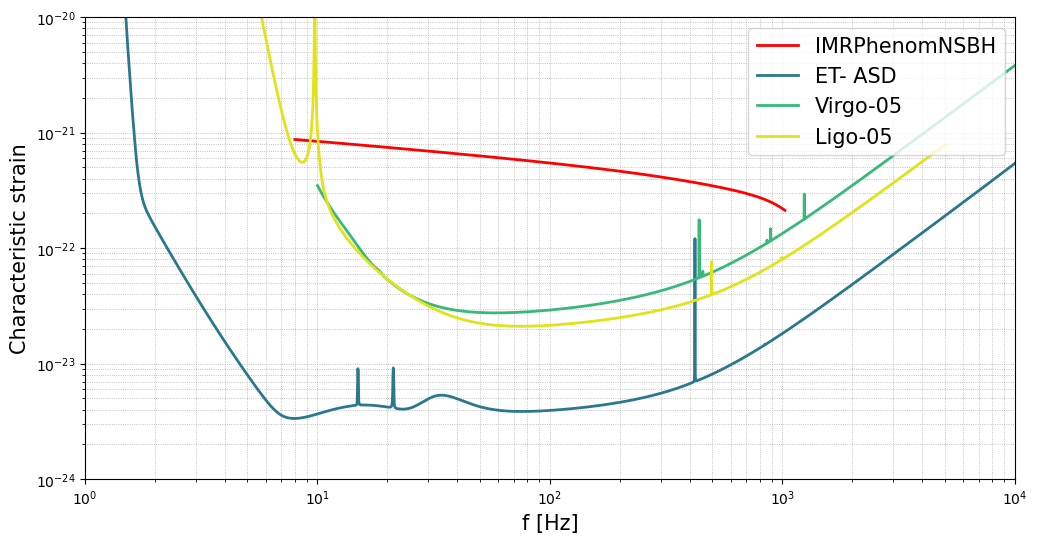

In [18]:
# The waveform model can be accessed through the waveform_class attribute,
# which requires the waveform_model and the data_params and the parameters of the event

waveform_class = gw.waveforms.LALFD_Waveform


data_params={
        'frequencyvector': selected_network.detectors[0].frequencyvector,
        'f_ref': 50.
        }

waveform_obj = waveform_class(waveform_model, parameters.iloc[0], data_params)
wave = waveform_obj()
t_of_f = waveform_obj.t_of_f


#------- The waveform is then projected onto the detector taking into account the Earth rotation 
#------- by passing at each frequency step the time of the waveform at the detector

#signal = gw.detection.projection(parameters.iloc[0],selected_network.detectors[0], wave, t_of_f)

# The projected amplitude is stored in the signal variable We have 3 columns as ET is made of 3 detectors
#signal1, signal2, signal3 = signal[:, 0], signal[:, 1], signal[:, 2]


signal1= gw.detection.projection(parameters.iloc[0], selected_network.detectors[0], wave, t_of_f)
signal2= gw.detection.projection(parameters.iloc[0], network_ligo_virgo.detectors[1], wave, t_of_f)
signal3= gw.detection.projection(parameters.iloc[0], network_ligo_virgo.detectors[2], wave, t_of_f)


signal_ampl = np.sqrt(np.abs(signal1)**2. + np.abs(signal2)**2. + np.abs(signal3)**2.)
print(len(signal_ampl))
print(signal_ampl.size)

# The PSD of the ET-D detector is stored in the detector_psd folder
# We need to specify the path to the file
GWFish_path = '/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/' 
psd_et = np.loadtxt(os.path.join(GWFish_path,'detector_psd/ET_psd.txt'), usecols=[0,1])
psd_virgo05 = np.loadtxt(os.path.join(GWFish_path,'detector_psd/Virgo_O5_psd.txt'), usecols=[0,1])
psd_Ligo05 = np.loadtxt(os.path.join(GWFish_path,'detector_psd/LIGO_O5_psd.txt'), usecols=[0,1])

frequencyvector = selected_network.detectors[0].frequencyvector # for ligo-virgo
#frequencyvector = selected_network.detectors[0].frequencyvector[:, 0] # for ET, why?

# plot -----------------------------------------------------------------------------------------------------------------------------------------------

# default,classic, bmh, dark_background, fivethirtyeight,ggplot, grayscale, seaborn-colorblind, seaborn-dark, seaborn-dark-palette,seaborn-darkgrid
# seaborn-deep, seaborn-muted,seaborn-notebook,seaborn-paper,seaborn-pastel,seaborn-poster,seaborn-poster,seaborn-talk,seaborn-ticks,seaborn-white,seaborn-whitegrid

plt.style.use('default')
fig, ax = plt.subplots(figsize=(12,6))

colors= plt.colormaps['viridis'](np.linspace(0.4, 0.95, 3))
#plt.cm.viridis, 

ax.plot(frequencyvector, 2. * frequencyvector * signal_ampl, linewidth=2., label='%s' %(waveform_model),color="red")

ax.plot(psd_et[:,0], np.sqrt(psd_et[:,0]) * np.sqrt(psd_et[:,1]), linewidth = 2.0, color = colors[0], label = 'ET- ASD')
ax.plot(psd_virgo05[:,0], np.sqrt(psd_virgo05[:,0]) * np.sqrt(psd_virgo05[:,1]), linewidth = 2.0, color=colors[1], label = 'Virgo-05')
ax.plot(psd_Ligo05[:,0], np.sqrt(psd_Ligo05[:,0]) * np.sqrt(psd_Ligo05[:,1]), linewidth = 2.0, color= colors[2], label = 'Ligo-05')

#ax.set_xlim(1.,frequencyvector[-1])
ax.set_xlim(1.,1e4)
ax.set_ylim(1e-24, 1e-20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('f [Hz]', fontsize=15)
ax.set_ylabel(r'Characteristic strain', fontsize=15)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
ax.legend(loc='upper right', fontsize=15, ncol=1, fancybox=True)

plt.show()



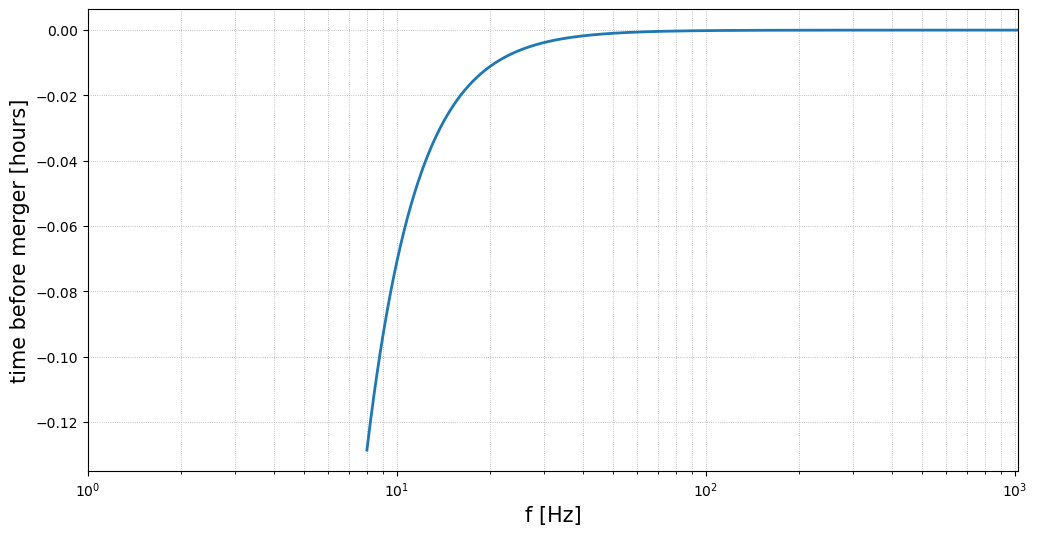

In [19]:
# Plot the time before merger as a function of frequency
fig, ax = plt.subplots(figsize = (12,6))
conv_to_hours = 3600
ax.plot(frequencyvector, (t_of_f - parameters['geocent_time'].iloc[0]) / conv_to_hours, linewidth = 2.)

ax.set_xlim(1.,frequencyvector[-1])
ax.set_xscale('log')
ax.set_xlabel('f [Hz]', fontsize = 15)
ax.set_ylabel(r'time before merger [hours]', fontsize=15)
plt.grid(linestyle = 'dotted', linewidth = '0.6', which = 'both')

plt.show()

### Usage of sub network lists and "analyze_and_save_to_txt" function


In [ ]:

    
def partial(network: gw. sub_network_ids: list[int]):
        
    new_network = copy.deepcopy(self)
        
    new_network.detectors = [
        self.detectors[i] for i in sub_network_ids
    ]
        

    return new_network

In [27]:
data_folder = '/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results_single_events'

multiple_networks = gw.detection.Network(detector_ids = ['LHO', 'LLO', 'VIR', 'CE1', 'ET'], detection_SNR = (0., 8.))

print(multiple_networks.name)
sub_network = [[0, 1, 2], [3, 4], [4]]

N=partial(multiple_networks,sub_network[0])





LHO_LLO_VIR_CE1_ET


In [49]:

network = gw.detection.Network(detector_ids = ['LHO', 'LLO', 'VIR', 'CE1', 'ET'], detection_SNR = (0., 8.))
sub_network_ids_list = [[0, 1, 2], [3, 4], [4]]

sub_network_ids_list[2]
                     

for sub_network_ids in sub_network_ids_list:

    partial_network = multiple_networks.partial(sub_network_ids)
    print(partial_network.name)

LHO_LLO_VIR_CE1_ET
LHO_LLO_VIR_CE1_ET
LHO_LLO_VIR_CE1_ET


In [ ]:
display(errors)

network_SNR  mass_1  mass_2  redshift  luminosity_distance  theta_jn   ra  \
0   305.978564     6.5     1.5      0.07                326.4       2.5  3.4   

   dec  psi  phase  ...   err_dec    err_ra  err_psi  err_phase  \
0 -0.4  0.0    0.0  ...  0.003519  0.002317   0.2153     0.3603   

   err_geocent_time  err_a_1  err_a_2  err_lambda_1  err_lambda_2  \
0          0.000399  0.05643    0.304          3.86         264.0   

   err_sky_location  
0          0.000022  

[1 rows x 29 columns]

In [54]:
data_folder = '/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results_single_events'

multiple_networks = gw.detection.Network(detector_ids = ['LHO', 'LLO', 'VIR', 'CE1', 'ET'], detection_SNR = (0., 8.))
sub_network_list = [[0, 1, 2], [3, 4], [4]]

gw.fishermatrix.analyze_and_save_to_txt(network = multiple_networks,
                                        parameter_values  = parameters,
                                        fisher_parameters = fisher_parameters, 
                                        sub_network_ids_list = sub_network_list,
                                        population_name = 'NSBH',
                                        waveform_model = waveform_model,
                                        save_path = data_folder,
                                        save_matrices = True,
                                      )


100%|██████████| 1/1 [00:55<00:00, 55.98s/it]


In [66]:
fisher_matrix = np.load(data_folder + '/' + 'fisher_matrices_ET_NSBH_SNR8.npy')
errors1 = pd.read_csv(data_folder + '/' + 'Errors_ET_NSBH_SNR8.txt', delimiter = ' ')
errors2 = pd.read_csv(data_folder + '/' + 'Errors_CE1_ET_NSBH_SNR8.txt', delimiter = ' ')
errors3 = pd.read_csv(data_folder + '/' + 'Errors_LHO_LLO_VIR_NSBH_SNR8.txt', delimiter = ' ')

print(errors1.keys())
display(errors1)
display(errors2)
display(errors3)

Index(['network_SNR', 'mass_1', 'mass_2', 'redshift', 'luminosity_distance',
       'theta_jn', 'ra', 'dec', 'psi', 'phase', 'geocent_time', 'a_1', 'a_2',
       'lambda_1', 'lambda_2', 'err_mass_1', 'err_mass_2',
       'err_luminosity_distance', 'err_theta_jn', 'err_dec', 'err_ra',
       'err_psi', 'err_phase', 'err_geocent_time', 'err_a_1', 'err_a_2',
       'err_lambda_1', 'err_lambda_2', 'err_sky_location'],
      dtype='object')


network_SNR  mass_1  mass_2  redshift  luminosity_distance  theta_jn   ra  \
0   305.978564     6.5     1.5      0.07                326.4       2.5  3.4   

   dec  psi  phase  ...   err_dec    err_ra  err_psi  err_phase  \
0 -0.4  0.0    0.0  ...  0.003519  0.002317   0.2153     0.3603   

   err_geocent_time  err_a_1  err_a_2  err_lambda_1  err_lambda_2  \
0          0.000399  0.05643    0.304          3.86         264.0   

   err_sky_location  
0          0.000022  

[1 rows x 29 columns]

network_SNR  mass_1  mass_2  redshift  luminosity_distance  theta_jn   ra  \
0   305.978564     6.5     1.5      0.07                326.4       2.5  3.4   

   dec  psi  phase  ...   err_dec    err_ra  err_psi  err_phase  \
0 -0.4  0.0    0.0  ...  0.003519  0.002317   0.2153     0.3603   

   err_geocent_time  err_a_1  err_a_2  err_lambda_1  err_lambda_2  \
0          0.000399  0.05643    0.304          3.86         264.0   

   err_sky_location  
0          0.000022  

[1 rows x 29 columns]

network_SNR  mass_1  mass_2  redshift  luminosity_distance  theta_jn   ra  \
0   305.978564     6.5     1.5      0.07                326.4       2.5  3.4   

   dec  psi  phase  ...   err_dec    err_ra  err_psi  err_phase  \
0 -0.4  0.0    0.0  ...  0.003519  0.002317   0.2153     0.3603   

   err_geocent_time  err_a_1  err_a_2  err_lambda_1  err_lambda_2  \
0          0.000399  0.05643    0.304          3.86         264.0   

   err_sky_location  
0          0.000022  

[1 rows x 29 columns]

In [61]:
my_fisher = fisher_matrix[0, :, :]
print('We expect Delta dL/dL to scale as 1/SNR')
print('fisher matrix dL-dL: ', my_fisher[2, 2])
print('(SNR/dL)^2: ', (errors['network_SNR'].iloc[0] / errors['luminosity_distance'].iloc[0])**2)

We expect Delta dL/dL to scale as 1/SNR
fisher matrix dL-dL:  0.8788845805169083
(SNR/dL)^2:  0.8787831140009711


In [68]:
CORNER_KWARGS = dict(
    bins = 50, # number of bins for histograms
    smooth = 0.99, # smooths out contours. 
    plot_datapoints = True, # choose if you want datapoints
    label_kwargs = dict(fontsize = 12), # font size for labels
    show_titles = True, #choose if you want titles on top of densities.
    title_kwargs = dict(fontsize = 12), # font size for title
    plot_density = False,
    title_quantiles = [0.16, 0.5, 0.84],  # add quantiles to plot densities for 1d hist
    levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), # 1, 2 and 3 sigma contours for 2d plots
    fill_contours = True, #decide if you want to fill the contours
    max_n_ticks = 2, # set a limit to ticks in the x-y axes.
    title_fmt=".3f"
    )
#corner_lbs = [r'$m_1$ $[M_{\odot}]$', '$m_2$ $[M_{\odot}]$', '$D_l$ [Mpc]', '$\iota$ [rad]', '$DEC$ [rad]', '$RA$ [rad]', '$\Psi$ [rad]',
#              '$phase$', '$t_c$', '$a_1$', '$a_2$', '$\Lambda_1$', '$\Lambda_2$']

corner_lbs = [r'$m_1$ $[M_{\odot}]$', '$m_2$ $[M_{\odot}]$', '$D_l$ [Mpc]' '$DEC$ [rad]', '$RA$ [rad]', '$a_1$', '$a_2$', '$\Lambda_1$', '$\Lambda_2$']

mean_lbs = ['mass_1', 'mass_2', 'luminosity_distance','dec', 'ra', 'a_1', 'a_2', 'lambda_1', 'lambda_2']

mean_values = parameters[mean_lbs].iloc[0] # mean values of the parameters
cov_matrix = np.load(data_folder + '/' + 'inv_fisher_matrices_ET_NSBH_SNR8.npy')[0, :, :]

# Sample from a multi-variate gaussian with the given covariance matrix and injected mean values
samples = np.random.multivariate_normal(mean_values, cov_matrix, int(1e6))

#-----------------------------------------------------------------------------------------------------------------

fig = corner.corner(samples, labels = corner_lbs, truths = mean_values, truth_color = 'red',
                    **CORNER_KWARGS)
plt.show()

ValueError: mean and cov must have same length

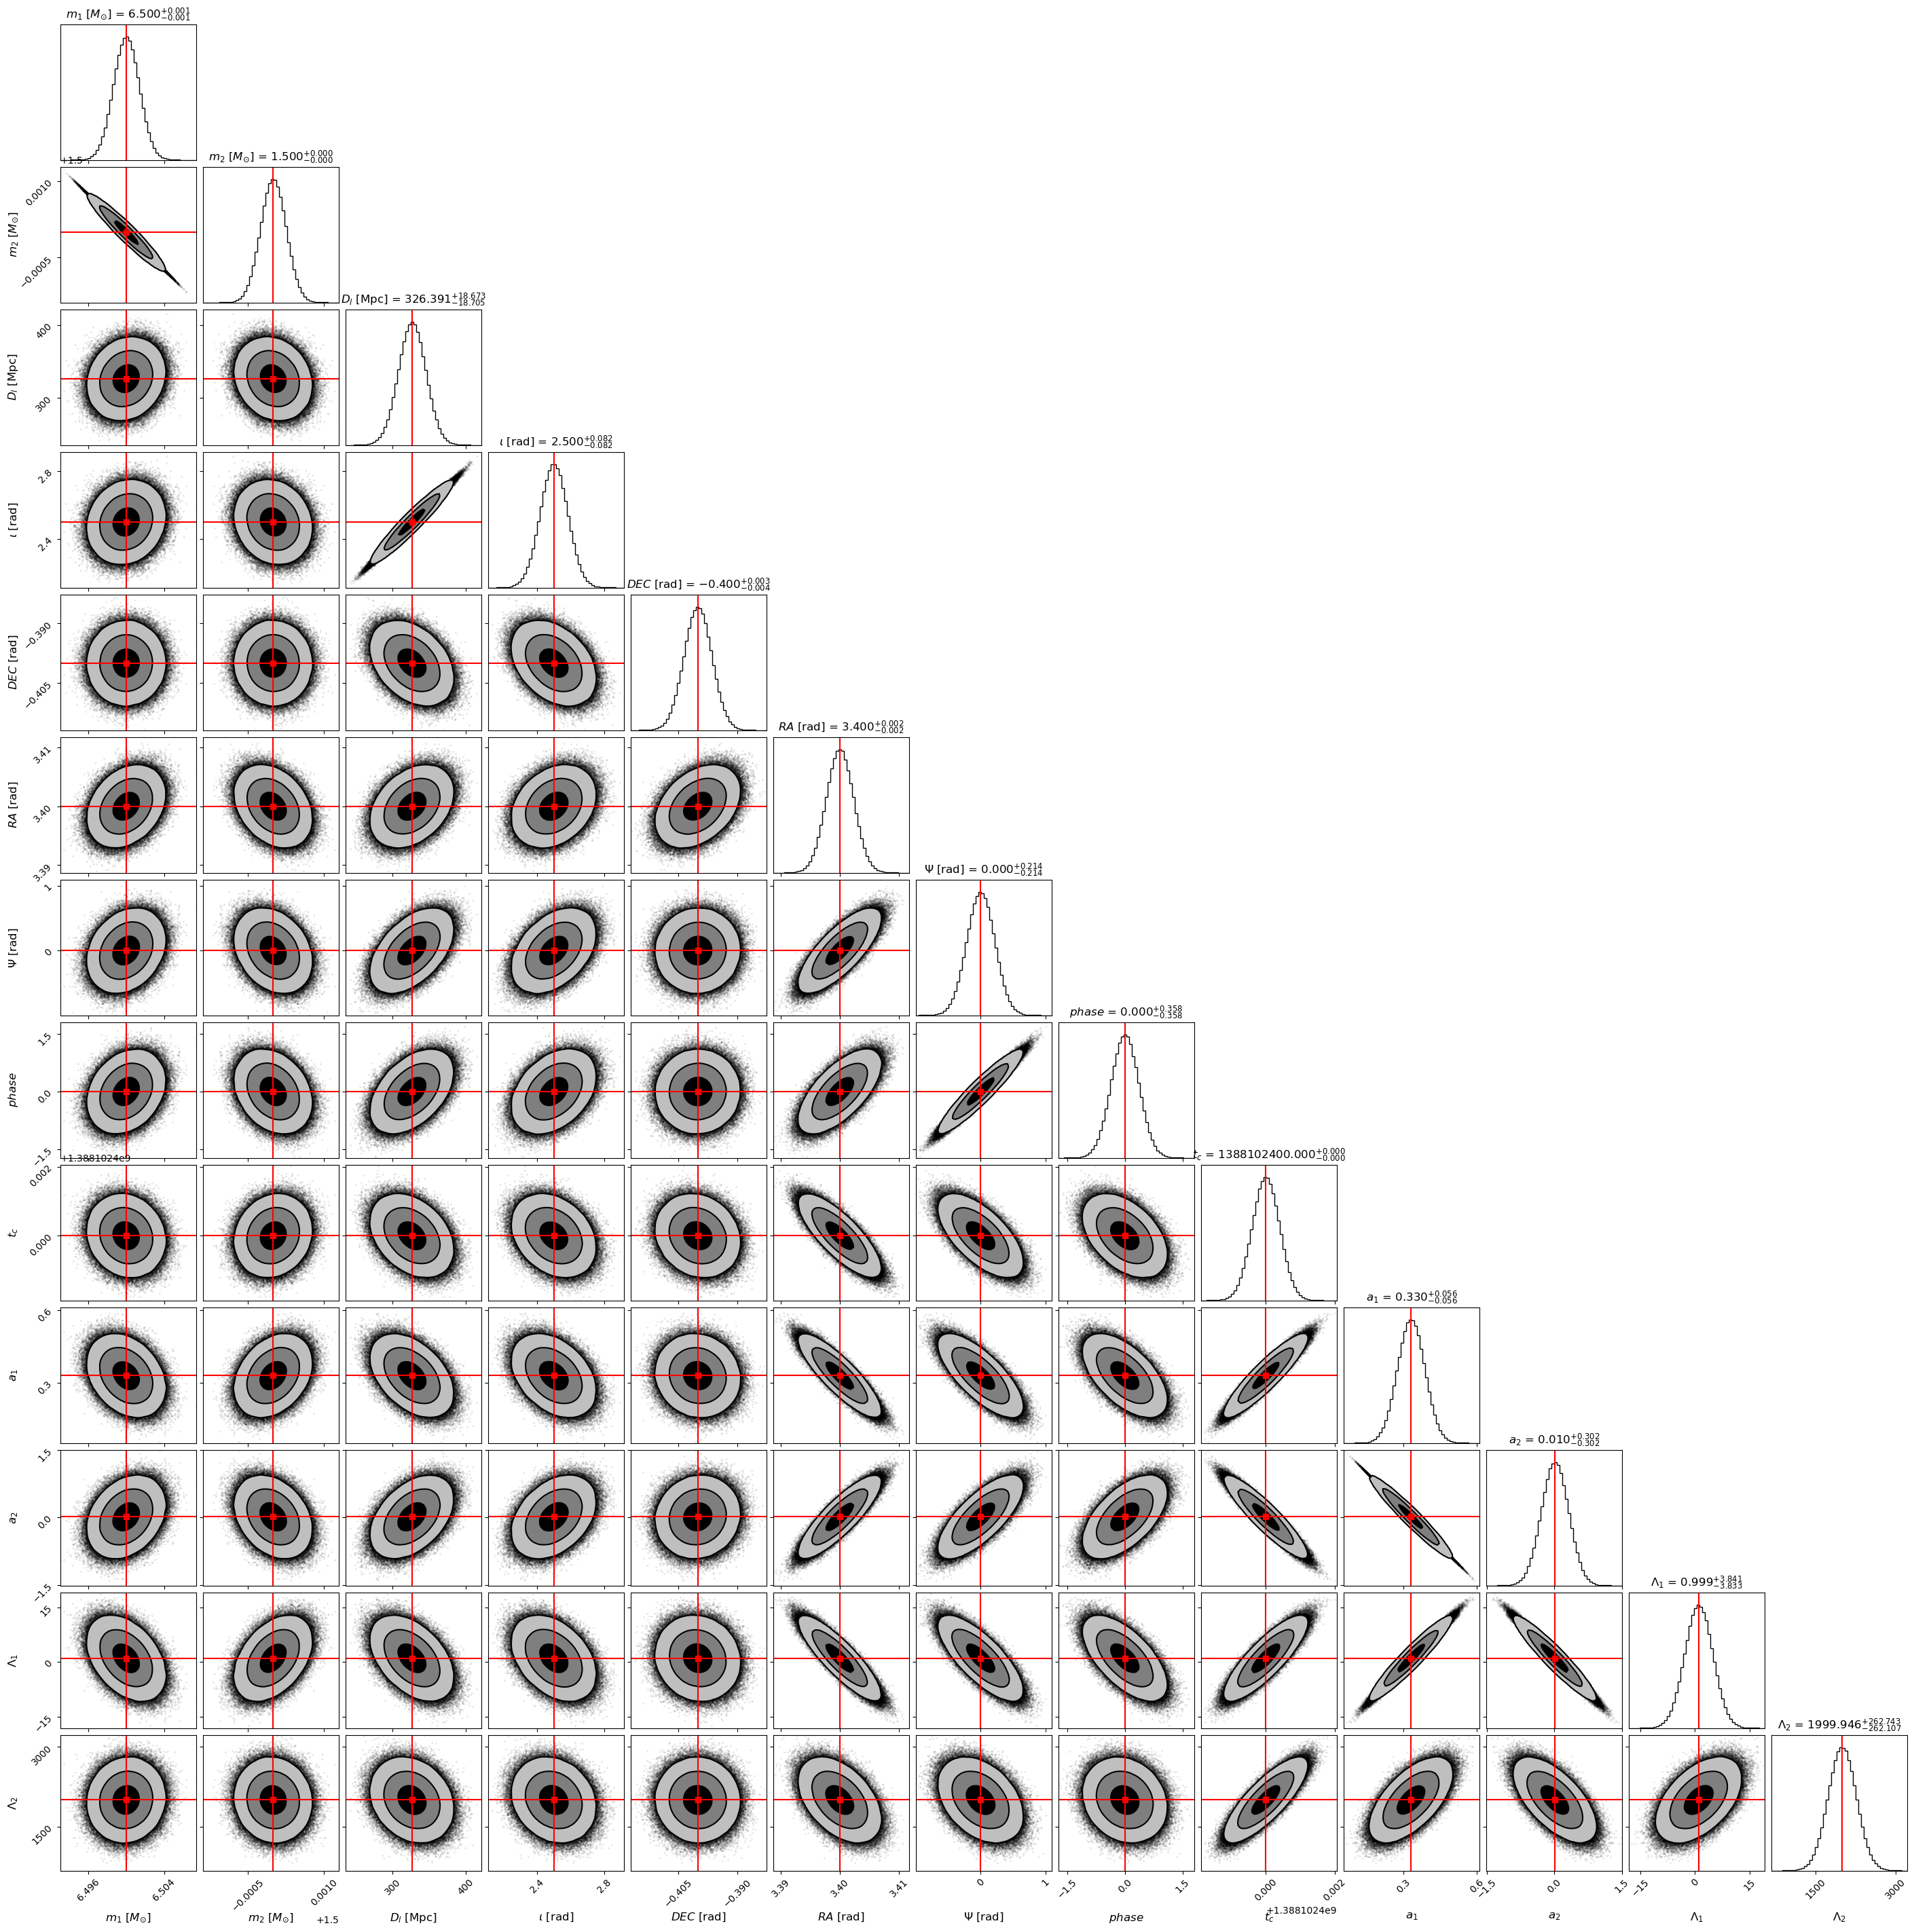

In [63]:
cov_matrix = np.load(data_folder + '/' + 'inv_fisher_matrices_CE1_ET_NSBH_SNR8.npy')[0, :, :]

# Sample from a multi-variate gaussian with the given covariance matrix and injected mean values
samples = np.random.multivariate_normal(mean_values, cov_matrix, int(1e6))

#-----------------------------------------------------------------------------------------------------------------

fig = corner.corner(samples, labels = corner_lbs, truths = mean_values, truth_color = 'red',
                    **CORNER_KWARGS)
plt.show()

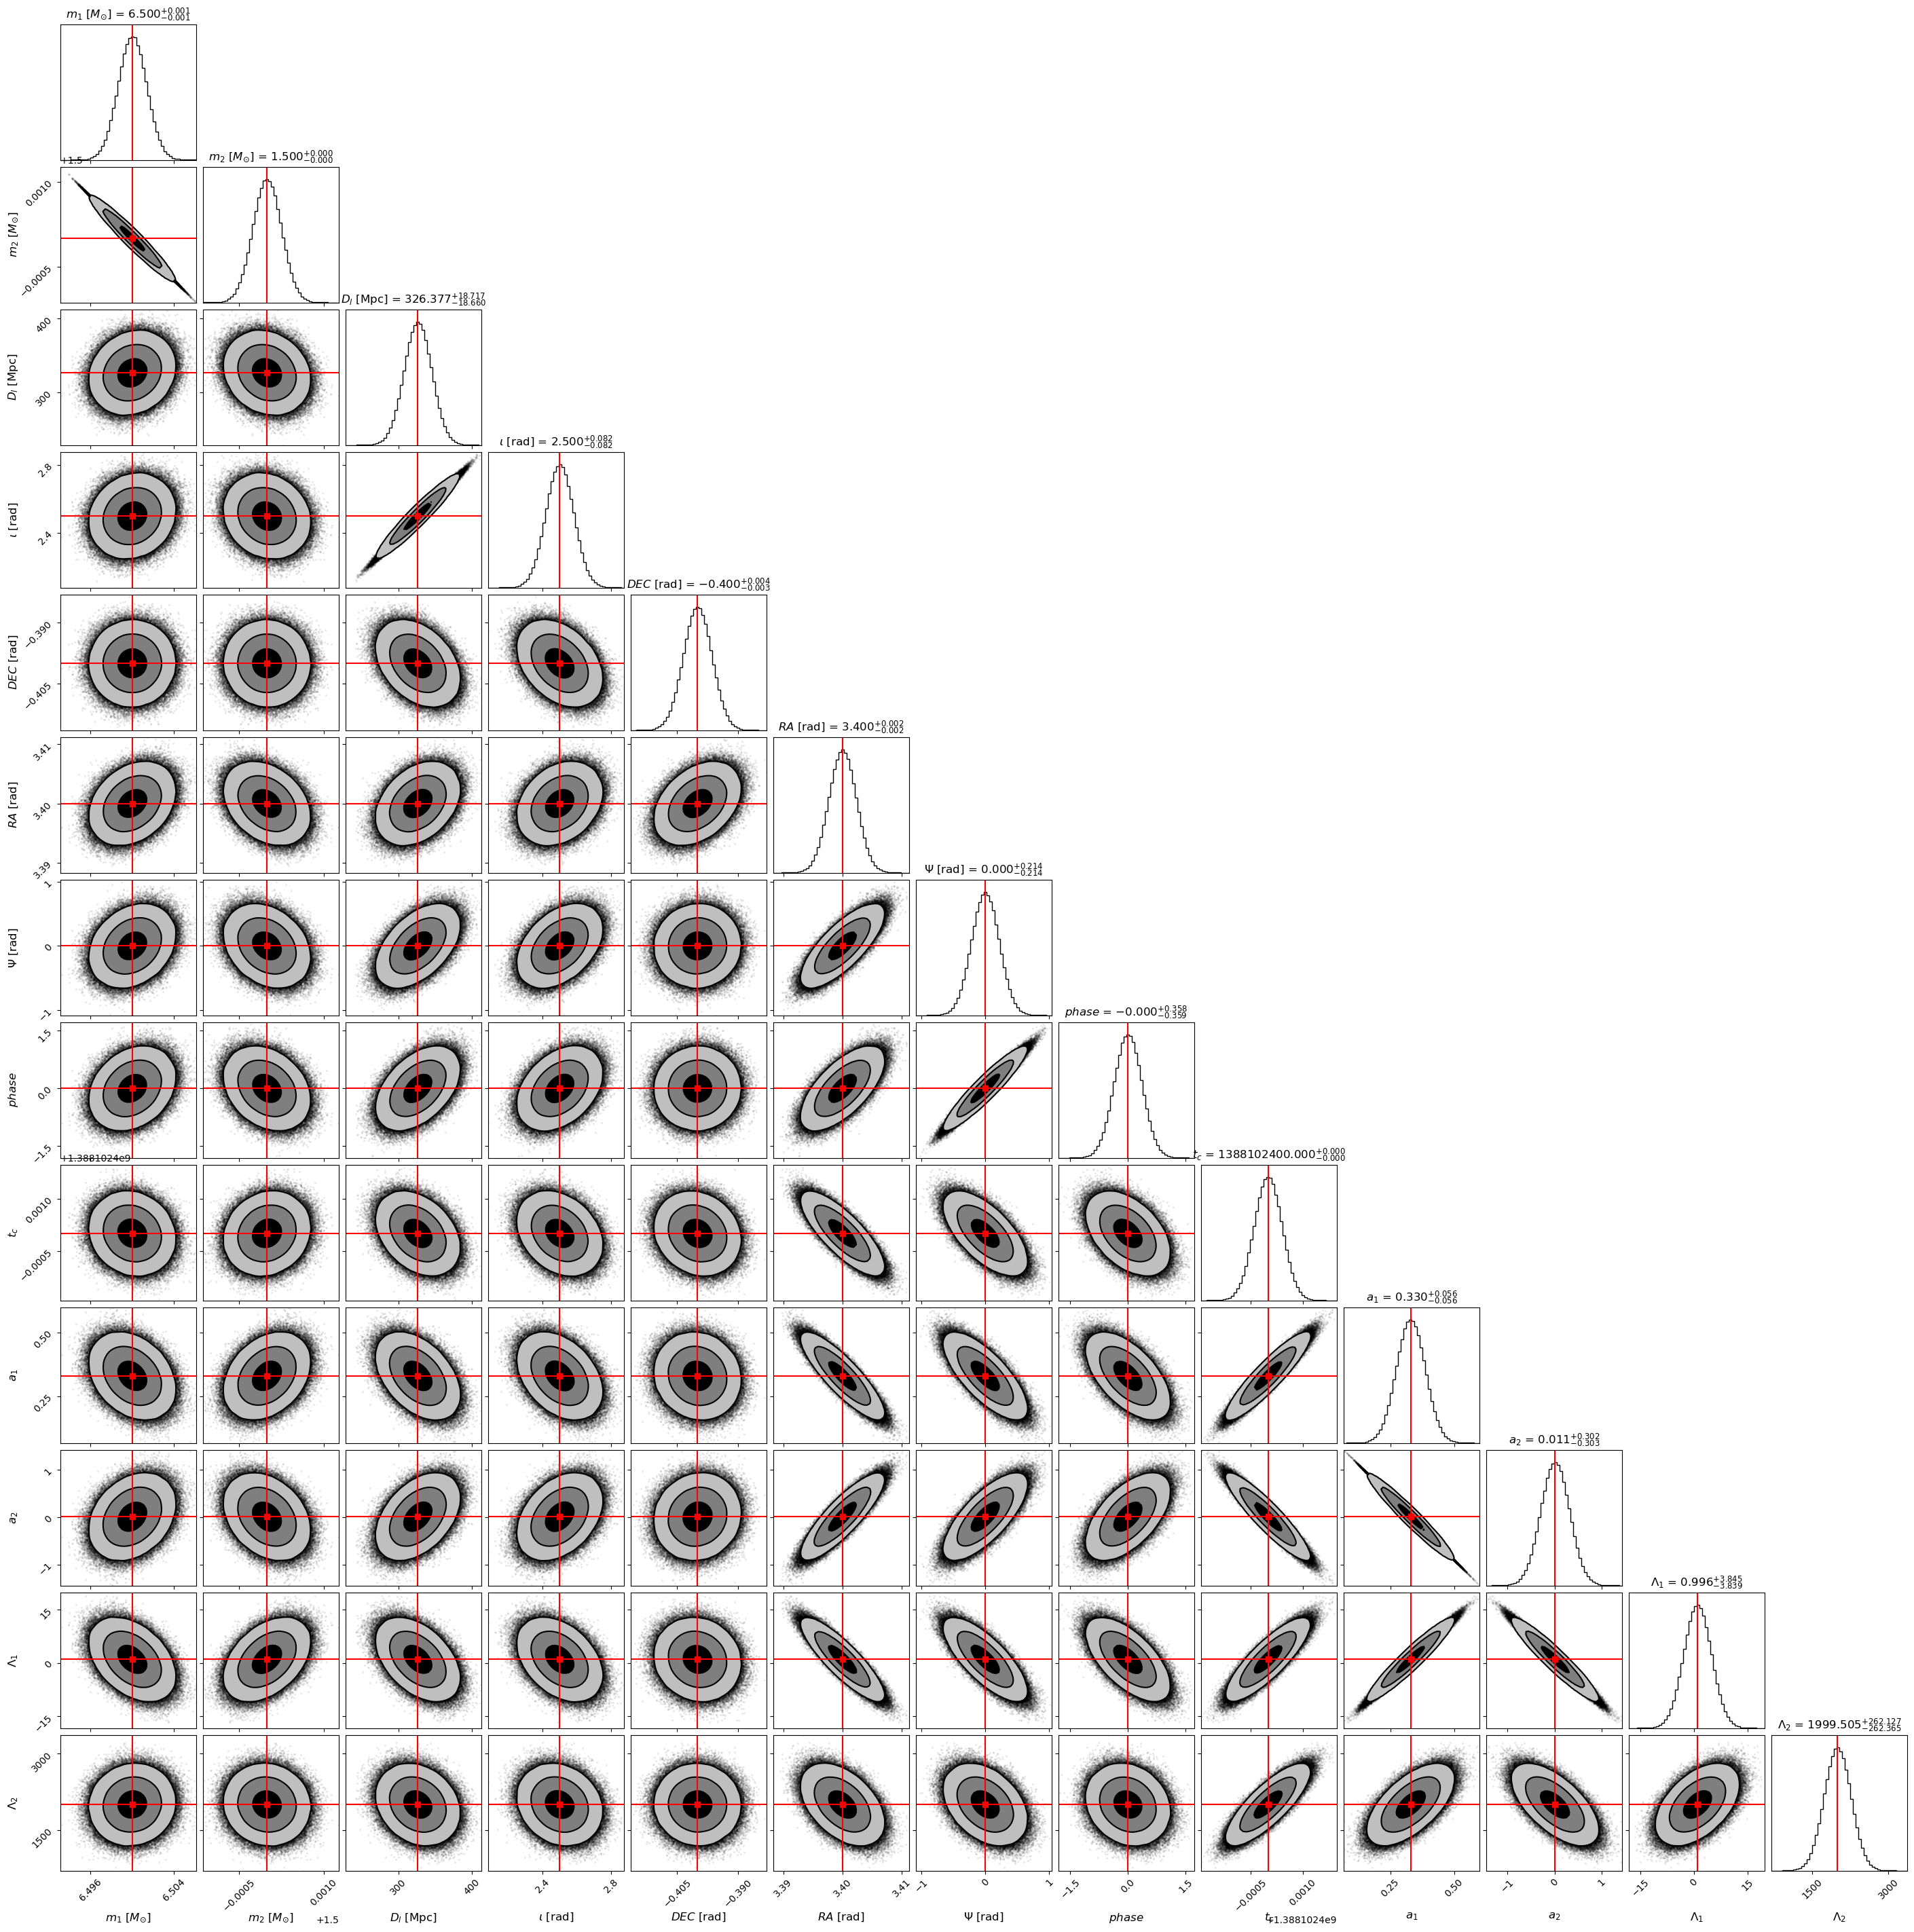

In [64]:
cov_matrix = np.load(data_folder + '/' + 'inv_fisher_matrices_LHO_LLO_VIR_NSBH_SNR8.npy')[0, :, :]

# Sample from a multi-variate gaussian with the given covariance matrix and injected mean values
samples = np.random.multivariate_normal(mean_values, cov_matrix, int(1e6))

#-----------------------------------------------------------------------------------------------------------------

fig = corner.corner(samples, labels = corner_lbs, truths = mean_values, truth_color = 'red',
                    **CORNER_KWARGS)
plt.show()

# NSBH population 

### Single Population data frame

In [8]:
#------------------------------------------------- Example for NSBH population -----------------------------------------------------------------

nev = 100 # number of events


my_dict = {}
my_dict['redshift'] = np.random.uniform(0.001, 0.1, nev)
my_dict['mass_1'] = np.random.uniform(4, 20, nev)
#my_dict['mass_2'] = np.random.uniform(1.1, 2.5, nev)
my_dict['mass_2'] = np.full(nev,1.4)

my_dict['luminosity_distance'] = Planck18.luminosity_distance(my_dict['redshift']).value
my_dict['theta_jn'] = np.arccos(np.random.uniform(-1., 1., nev))
my_dict['ra'] = np.random.uniform(0., 2 * np.pi, nev)
my_dict['dec'] = np.arcsin(np.random.uniform(-1., 1., nev))
my_dict['psi'] = np.random.uniform(0., np.pi, nev)
my_dict['phase'] = np.random.uniform(0., 2 * np.pi, nev)

my_dict['geocent_time'] = np.random.uniform(1388102400.0, 1403740800.0, nev) #from 1 January 2024 to 30 June 2024
my_dict['a_1'] = np.random.uniform(-0.5, 0.75, nev)
my_dict['a_2'] = np.random.uniform(0., 0.05, nev)
my_dict['lambda_1'] = np.full(nev,1)
my_dict['lambda_2'] = np.random.uniform(100., 2000., nev)

aux_mass = my_dict['mass_1']
my_dict['mass_1'] = np.maximum(aux_mass, my_dict['mass_2'])
my_dict['mass_2'] = np.minimum(aux_mass, my_dict['mass_2'])


my_dict = pd.DataFrame(my_dict)
display(my_dict)


redshift     mass_1  mass_2  luminosity_distance  theta_jn        ra  \
0   0.066058   8.967506     1.4           307.159784  1.225918  0.614869   
1   0.094476  10.351280     1.4           447.891601  0.709987  6.222450   
2   0.028327  11.070234     1.4           128.208760  1.233693  0.971231   
3   0.081384   4.580971     1.4           382.435392  1.975448  0.198582   
4   0.089909   7.030065     1.4           424.938411  0.627684  2.449949   
..       ...        ...     ...                  ...       ...       ...   
95  0.066626  13.622630     1.4           309.925182  2.184689  1.076147   
96  0.039609  14.215195     1.4           180.752584  2.184437  4.289433   
97  0.094070  16.027826     1.4           445.843754  2.667021  2.960879   
98  0.082821   5.403272     1.4           389.568483  0.815830  3.168457   
99  0.081316  15.821690     1.4           382.095750  1.349750  2.474714   

         dec       psi     phase  geocent_time       a_1       a_2  lambda_1  \
0  -0.461852  1.711049  1.759983  1.402647e+09  0.360712  0.024681         1   
1   0.340286  1.353833  5.301270  1.389262e+09  0.642294  0.048030         1   
2  -0.620773  1.992269  4.949768  1.401997e+09  0.711465  0.038356         1   
3  -1.004329  0.631965  4.742179  1.403048e+09  0.424288  0.032355         1   
4  -0.509655  1.229481  1.964463  1.400970e+09 -0.435783  0.036479         1   
..       ...       ...       ...           ...       ...       ...       ...   
95  0.148979  0.268241  4.572022  1.398705e+09  0.626354  0.033426         1   
96 -0.472193  0.254558  2.066252  1.396543e+09 -0.133780  0.047072         1   
97 -0.959520  2.366789  3.866693  1.402066e+09  0.563837  0.041950         1   
98 -0.676261  1.993034  2.093870  1.391713e+09 -0.135256  0.008210         1   
99 -0.043508  2.656512  6.250259  1.399953e+09 -0.229097  0.045306         1   

       lambda_2  
0    507.654209  
1    793.809615  
2   1914.254380  
3   1729.924835  
4    333.393626  
..          ...  
95  1520.112641  
96  1523.817452  
97   308.932826  
98   871.604301  
99  1418.114326  

[100 rows x 14 columns]

### Multiple redshift (z) schells data frames

In [38]:

nev = 100 # number of events
all_dataframes = {}

z_schells=[0,0.001,0.01,0.1,1]

for i in range(len(z_schells)-1):
   
    my_dict = {}
    my_dict['redshift'] = np.random.uniform(z_schells[i], z_schells[i+1], nev)
    my_dict['mass_1'] = np.random.uniform(4, 20, nev)
    #my_dict['mass_2'] = np.random.uniform(1.1, 2.5, nev)
    my_dict['mass_2'] = np.full(nev,1.4)

    my_dict['luminosity_distance'] = Planck18.luminosity_distance(my_dict['redshift']).value
    my_dict['theta_jn'] = np.arccos(np.random.uniform(-1., 1., nev))
    my_dict['ra'] = np.random.uniform(0., 2 * np.pi, nev)
    my_dict['dec'] = np.arcsin(np.random.uniform(-1., 1., nev))
    my_dict['psi'] = np.random.uniform(0., np.pi, nev)
    my_dict['phase'] = np.random.uniform(0., 2 * np.pi, nev)

    my_dict['geocent_time'] = np.random.uniform(1388102400.0, 1401235200.0, nev)
    my_dict['a_1'] = np.random.uniform(-0.5, 0.75, nev)
    my_dict['a_2'] = np.random.uniform(0., 0.05, nev)
    my_dict['lambda_1'] = np.full(nev,1)
    my_dict['lambda_2'] = np.random.uniform(100., 2000., nev)

    aux_mass = my_dict['mass_1']
    my_dict['mass_1'] = np.maximum(aux_mass, my_dict['mass_2'])
    my_dict['mass_2'] = np.minimum(aux_mass, my_dict['mass_2'])


    my_dict = pd.DataFrame(my_dict)
    #display(my_dict)
        
    dataframe_name = f"dataframe_z_{z_schells[i]}-{z_schells[i+1]}"  # Puoi usare qualsiasi schema di denominazione desiderato
    all_dataframes[dataframe_name] = my_dict


for name, dataframe in all_dataframes.items():
    #print(f"{name}:\n{dataframe}\n")
    print(f"{name}:")
    display(dataframe)
    

    

dataframe_z_0-0.001:


redshift     mass_1  mass_2  luminosity_distance  theta_jn        ra  \
0   0.000775   8.380361     1.4             3.434520  2.631910  4.076713   
1   0.000575  18.226925     1.4             2.549602  1.884009  2.792138   
2   0.000717  12.426723     1.4             3.179931  1.114441  4.495882   
3   0.000396  19.770814     1.4             1.756276  0.961582  2.158789   
4   0.000812   9.774977     1.4             3.599234  2.711068  5.980574   
..       ...        ...     ...                  ...       ...       ...   
95  0.000974  15.589179     1.4             4.318282  1.818378  2.977202   
96  0.000386  10.195018     1.4             1.712432  2.191936  3.116906   
97  0.000384   6.425119     1.4             1.702228  1.636808  0.479987   
98  0.000488  13.324583     1.4             2.164139  0.448058  2.593249   
99  0.000065   7.028365     1.4             0.287718  0.430329  1.549731   

         dec       psi     phase  geocent_time       a_1       a_2  lambda_1  \
0   0.832896  3.054002  2.737490  1.391851e+09  0.474722  0.010774         1   
1  -0.220865  0.296987  2.130125  1.396383e+09 -0.074147  0.001535         1   
2   1.188761  0.142577  6.160085  1.399052e+09  0.143016  0.021062         1   
3  -0.254647  0.898568  2.454071  1.401084e+09 -0.279599  0.036690         1   
4   0.008430  2.926728  2.201999  1.396268e+09 -0.045516  0.000596         1   
..       ...       ...       ...           ...       ...       ...       ...   
95  0.962823  1.185583  3.472481  1.399446e+09 -0.099780  0.004295         1   
96 -0.426693  3.007737  6.215022  1.399852e+09 -0.125369  0.020365         1   
97 -0.171164  0.908589  6.081083  1.399359e+09 -0.369764  0.011451         1   
98  0.122000  1.477792  2.111793  1.389376e+09  0.506563  0.022485         1   
99  0.883310  0.786277  4.616303  1.399473e+09  0.629138  0.018516         1   

       lambda_2  
0    906.375548  
1    747.745638  
2   1726.861611  
3   1535.200769  
4   1313.897658  
..          ...  
95  1690.659422  
96  1119.263144  
97  1125.141847  
98  1717.702051  
99   628.247896  

[100 rows x 14 columns]

dataframe_z_0.001-0.01:


redshift     mass_1  mass_2  luminosity_distance  theta_jn        ra  \
0   0.004545   5.126631     1.4            20.208191  2.106536  4.343426   
1   0.005255   4.645438     1.4            23.377019  2.954824  0.228204   
2   0.001834  19.398870     1.4             8.138820  2.379371  4.246253   
3   0.008867  15.090033     1.4            39.554982  1.461026  0.620491   
4   0.005808  10.489489     1.4            25.848840  2.205059  3.085603   
..       ...        ...     ...                  ...       ...       ...   
95  0.004093  14.501154     1.4            18.193880  2.472243  3.055985   
96  0.002440  11.108516     1.4            10.830461  1.389443  0.932099   
97  0.002960  16.290206     1.4            13.143870  2.857560  4.771530   
98  0.006958   9.622154     1.4            30.995515  0.631626  0.941346   
99  0.008534   9.778996     1.4            38.057477  2.626061  6.058651   

         dec       psi     phase  geocent_time       a_1       a_2  lambda_1  \
0  -0.615225  2.704774  5.703342  1.396882e+09 -0.366985  0.014697         1   
1  -0.796329  1.756167  1.692820  1.392060e+09  0.474300  0.049426         1   
2  -1.544620  1.490525  1.865128  1.395834e+09  0.505356  0.048529         1   
3   0.628853  0.518194  1.288607  1.390244e+09 -0.449209  0.039413         1   
4   0.095549  3.070566  4.136447  1.393016e+09 -0.211434  0.022741         1   
..       ...       ...       ...           ...       ...       ...       ...   
95  0.459708  0.453403  4.072739  1.401118e+09 -0.235045  0.031974         1   
96 -0.907746  2.634478  4.460941  1.394966e+09  0.535116  0.002962         1   
97 -0.217919  3.004985  5.521761  1.401040e+09 -0.153332  0.006845         1   
98 -0.229270  1.659079  3.661454  1.394741e+09  0.716825  0.036160         1   
99 -0.499951  2.156295  2.317071  1.398287e+09  0.537339  0.021978         1   

       lambda_2  
0    698.841475  
1   1334.386304  
2    759.325071  
3   1984.428627  
4   1482.696290  
..          ...  
95   742.025458  
96   367.775755  
97  1193.085456  
98   360.783996  
99  1893.144220  

[100 rows x 14 columns]

dataframe_z_0.01-0.1:


redshift     mass_1  mass_2  luminosity_distance  theta_jn        ra  \
0   0.091311  11.854408     1.4           431.967295  1.901959  0.844456   
1   0.073770   5.637670     1.4           344.852442  1.953410  3.547241   
2   0.053371  19.381256     1.4           245.968615  1.071940  1.972309   
3   0.065241   8.395768     1.4           303.191006  1.503846  2.117289   
4   0.032543   5.954045     1.4           147.748998  1.660944  3.089630   
..       ...        ...     ...                  ...       ...       ...   
95  0.031618  16.513055     1.4           143.453104  0.461013  3.549815   
96  0.017632   9.401120     1.4            79.172080  1.804183  2.465507   
97  0.017433  19.110899     1.4            78.267316  1.289703  4.382170   
98  0.056419  11.789737     1.4           260.576183  2.174212  0.439099   
99  0.087997  18.951152     1.4           415.363386  1.233813  5.880898   

         dec       psi     phase  geocent_time       a_1       a_2  lambda_1  \
0  -1.278096  0.334263  2.823608  1.390912e+09 -0.350458  0.036588         1   
1  -0.372832  1.303325  1.517386  1.399691e+09 -0.388213  0.002794         1   
2   1.011535  0.600312  3.804019  1.398221e+09 -0.173007  0.019514         1   
3   0.078639  1.002253  5.717047  1.392352e+09  0.262343  0.026870         1   
4  -0.579540  1.306935  4.015502  1.393164e+09 -0.460247  0.020600         1   
..       ...       ...       ...           ...       ...       ...       ...   
95  0.481997  2.744598  2.000075  1.396023e+09  0.371760  0.017981         1   
96  0.233731  2.799401  0.798035  1.399090e+09 -0.167883  0.033981         1   
97  0.946254  2.640156  6.100730  1.394540e+09  0.359792  0.012307         1   
98  0.444153  3.023077  6.179324  1.391774e+09  0.567742  0.022508         1   
99  0.071153  2.185856  2.069776  1.400971e+09 -0.114491  0.038940         1   

       lambda_2  
0    879.942991  
1    159.727960  
2   1421.507147  
3    130.497922  
4   1066.732417  
..          ...  
95   343.828745  
96   775.106623  
97   256.004160  
98   193.440446  
99   159.183872  

[100 rows x 14 columns]

dataframe_z_0.1-1:


redshift     mass_1  mass_2  luminosity_distance  theta_jn        ra  \
0   0.564567  13.704296     1.4          3378.164598  1.746006  1.824701   
1   0.498752   7.624981     1.4          2910.905914  2.253565  3.642361   
2   0.708744  16.948124     1.4          4451.525384  1.533957  2.618172   
3   0.336606   9.222968     1.4          1830.749348  1.969818  0.096945   
4   0.212289  19.785397     1.4          1082.062133  2.547548  5.417032   
..       ...        ...     ...                  ...       ...       ...   
95  0.371490  19.603610     1.4          2053.891044  0.632793  4.392408   
96  0.268538  11.988456     1.4          1411.420857  1.740762  5.790911   
97  0.954649  14.390735     1.4          6414.003999  0.841769  0.961248   
98  0.178399  14.277482     1.4           891.631746  0.882981  1.983186   
99  0.680661   8.159375     1.4          4237.480752  2.057976  1.099347   

         dec       psi     phase  geocent_time       a_1       a_2  lambda_1  \
0  -0.784423  1.824960  4.154395  1.401104e+09  0.546822  0.026630         1   
1   0.236641  1.987392  3.771381  1.388838e+09  0.361285  0.013692         1   
2  -0.385898  0.716749  4.674967  1.393976e+09  0.144415  0.024972         1   
3   0.821116  1.449270  1.455360  1.399451e+09 -0.147662  0.030239         1   
4  -0.043227  0.807150  4.367894  1.390451e+09  0.573232  0.038186         1   
..       ...       ...       ...           ...       ...       ...       ...   
95 -0.614666  2.638677  4.357965  1.388230e+09  0.476353  0.038386         1   
96 -0.307790  0.754864  5.578177  1.396302e+09  0.458281  0.040009         1   
97 -0.435027  0.080171  5.461151  1.394449e+09  0.192141  0.024851         1   
98 -0.594480  1.279549  6.024512  1.390832e+09  0.326210  0.005424         1   
99  0.343012  1.621095  6.279007  1.392122e+09 -0.206961  0.033515         1   

       lambda_2  
0   1999.021223  
1   1952.956621  
2    556.101083  
3   1965.985852  
4   1516.520048  
..          ...  
95   983.497358  
96  1542.504878  
97  1914.913672  
98   119.067623  
99  1230.307692  

[100 rows x 14 columns]

In [9]:
detectors_pop = ['ET']
network_pop = gw.detection.Network(detector_ids = detectors_pop, detection_SNR = (0., 8.))
waveform_model_pop = 'IMRPhenomNSBH'
fisher_parameters_pop = ['redshift','mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'dec','ra',
                     'psi', 'phase', 'geocent_time', 'a_1', 'a_2', 'lambda_1', 'lambda_2']

In [10]:
data_folder_pop = '/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results'

gw.fishermatrix.analyze_and_save_to_txt(network = network_pop,
                                        parameter_values  = my_dict,
                                        fisher_parameters = fisher_parameters_pop, 
                                        sub_network_ids_list = [[0]],
                                        population_name = 'NSBH',
                                        waveform_model = waveform_model_pop,
                                        save_path = data_folder_pop,
                                        save_matrices = True)


100%|██████████| 100/100 [22:17<00:00, 13.37s/it]


In [11]:
data_folder_pop = '/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results'
pop_errors = pd.read_csv(data_folder_pop + '/' + 'Errors_ET_NSBH_SNR8.txt', delimiter = ' ')
pop_errors.iloc[0]

network_SNR                1.258117e+02
redshift                   6.606000e-02
mass_1                     8.968000e+00
mass_2                     1.400000e+00
luminosity_distance        3.072000e+02
theta_jn                   1.226000e+00
ra                         6.149000e-01
dec                       -4.619000e-01
psi                        1.711000e+00
phase                      1.760000e+00
geocent_time               1.403000e+09
a_1                        3.607000e-01
a_2                        2.468000e-02
lambda_1                   1.000000e+00
lambda_2                   5.077000e+02
err_redshift               2.560000e-03
err_mass_1                 1.778000e-01
err_mass_2                 2.643000e-02
err_luminosity_distance    1.741000e+01
err_theta_jn               1.289000e-01
err_dec                    1.668000e-01
err_ra                     9.216000e-02
err_psi                    9.883000e-02
err_phase                  5.196000e-01
err_geocent_time           3.634000e-03


In [53]:
path_to_means_file = data_folder_pop + '/' + 'Errors_ET_NSBH_SNR8.txt'
pop_errors = pd.read_csv(path_to_means_file, delimiter = ' ')

path_to_cov_mat_file = data_folder_pop + '/' + 'inv_fisher_matrices_ET_NSBH_SNR8.npy'

means_data_labels = [
                    'network_SNR',                
                    'redshift',                   
                    'mass_1',                    
                    'mass_2',                     
                    'luminosity_distance',        
                    'theta_jn',                   
                    'ra',                         
                    'dec',                        
                    'psi',                        
                    'phase',                      
                    'geocent_time',               
                    'a_1',                        
                    'a_2',                        
                    'lambda_1',                   
                    'lambda_2',                   
                    'err_mass_1',                 
                    'err_mass_2',                 
                    'err_luminosity_distance',    
                    'err_theta_jn',               
                    'err_dec',                   
                    'err_ra',                    
                    'err_psi',                    
                    'err_phase',                  
                    'err_geocent_time',           
                    'err_a_1',                    
                    'err_a_2',                    
                    'err_lambda_1',               
                    'err_lambda_2',              
                    'err_redshift',               
                    'err_sky_location'         
]

#means_data = pd.read_csv(path_to_means_file, names = means_data_labels, delimiter = ' ',
#                        low_memory = False)

cov_data = np.load(path_to_cov_mat_file)

means_data=pop_errors

means_data

network_SNR  redshift  mass_1  mass_2  luminosity_distance  theta_jn  \
0    125.811712   0.06606   8.968     1.4                307.2    1.2260   
1    127.770812   0.09448  10.350     1.4                447.9    0.7100   
2    532.639189   0.02833  11.070     1.4                128.2    1.2340   
3    107.869563   0.08138   4.581     1.4                382.4    1.9750   
4    127.618559   0.08991   7.030     1.4                424.9    0.6277   
..          ...       ...     ...     ...                  ...       ...   
95   186.790624   0.06663  13.620     1.4                309.9    2.1850   
96   546.615295   0.03961  14.220     1.4                180.8    2.1840   
97   153.556857   0.09407  16.030     1.4                445.8    2.6670   
98   155.564738   0.08282   5.403     1.4                389.6    0.8158   
99   146.493423   0.08132  15.820     1.4                382.1    1.3500   

        ra      dec     psi  phase  ...  err_dec   err_ra  err_psi  err_phase  \
0   0.6149 -0.46190  1.7110  1.760  ...  0.16680  0.09216  0.09883    0.51960   
1   6.2220  0.34030  1.3540  5.301  ...  0.06461  0.06651  1.12100    2.39300   
2   0.9712 -0.62080  1.9920  4.950  ...  0.27860  0.16010  0.14870    0.06093   
3   0.1986 -1.00400  0.6320  4.742  ...  0.15930  0.27880  0.32430    0.30110   
4   2.4500 -0.50970  1.2290  1.964  ...  0.05595  0.06547  1.51900    3.06900   
..     ...      ...     ...    ...  ...      ...      ...      ...        ...   
95  1.0760  0.14900  0.2682  4.572  ...  0.11010  0.08509  0.21490    0.62280   
96  4.2890 -0.47220  0.2546  2.066  ...  0.31850  0.12560  0.12550    0.23030   
97  2.9610 -0.95950  2.3670  3.867  ...  0.05381  0.09553  9.29100   18.63000   
98  3.1680 -0.67630  1.9930  2.094  ...  0.11870  0.15490  0.45070    0.73100   
99  2.4750 -0.04351  2.6570  6.250  ...  0.27760  0.48100  0.16380    1.08900   

    err_geocent_time  err_a_1  err_a_2  err_lambda_1  err_lambda_2  \
0           0.003634  0.15130   1.2450       12.6000        1740.0   
1           0.001762  0.07850   0.7558        1.7860        1208.0   
2           0.000668  0.01138   0.1213        0.1895         129.4   
3           0.002782  0.27660   1.0930       10.8400         440.5   
4           0.002017  0.20380   1.3260       14.1500         859.5   
..               ...      ...      ...           ...           ...   
95          0.001873  0.03792   0.4926        0.8544        1568.0   
96          0.001689  0.03080   0.4277       27.6000        1493.0   
97          0.001908  0.04006   0.6107        1.1390        3818.0   
98          0.002197  0.22430   1.0510       90.3900         532.2   
99          0.005039  0.11380   1.7660       36.2300        5674.0   

    err_sky_location  
0           0.041520  
1           0.012710  
2           0.066350  
3           0.074820  
4           0.010040  
..               ...  
95          0.028260  
96          0.086260  
97          0.008483  
98          0.042040  
99          0.402500  

[100 rows x 30 columns]

In [13]:
# List the parameters as they appear in the covariance matrix
var_in_cov_matrix = ['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'dec', 'ra', 'psi', 
                     'phase','geocent_time','a_1','a_2','lambda_1','lambda_2','redshift']

# Take the corresponding columns to create the vector of mean values
means = means_data[var_in_cov_matrix]
means

mass_1  mass_2  luminosity_distance  theta_jn      dec      ra     psi  \
0    8.968     1.4                307.2    1.2260 -0.46190  0.6149  1.7110   
1   10.350     1.4                447.9    0.7100  0.34030  6.2220  1.3540   
2   11.070     1.4                128.2    1.2340 -0.62080  0.9712  1.9920   
3    4.581     1.4                382.4    1.9750 -1.00400  0.1986  0.6320   
4    7.030     1.4                424.9    0.6277 -0.50970  2.4500  1.2290   
..     ...     ...                  ...       ...      ...     ...     ...   
95  13.620     1.4                309.9    2.1850  0.14900  1.0760  0.2682   
96  14.220     1.4                180.8    2.1840 -0.47220  4.2890  0.2546   
97  16.030     1.4                445.8    2.6670 -0.95950  2.9610  2.3670   
98   5.403     1.4                389.6    0.8158 -0.67630  3.1680  1.9930   
99  15.820     1.4                382.1    1.3500 -0.04351  2.4750  2.6570   

    phase  geocent_time     a_1      a_2  lambda_1  lambda_2  redshift  
0   1.760  1.403000e+09  0.3607  0.02468       1.0     507.7   0.06606  
1   5.301  1.389000e+09  0.6423  0.04803       1.0     793.8   0.09448  
2   4.950  1.402000e+09  0.7115  0.03836       1.0    1914.0   0.02833  
3   4.742  1.403000e+09  0.4243  0.03236       1.0    1730.0   0.08138  
4   1.964  1.401000e+09 -0.4358  0.03648       1.0     333.4   0.08991  
..    ...           ...     ...      ...       ...       ...       ...  
95  4.572  1.399000e+09  0.6264  0.03343       1.0    1520.0   0.06663  
96  2.066  1.397000e+09 -0.1338  0.04707       1.0    1524.0   0.03961  
97  3.867  1.402000e+09  0.5638  0.04195       1.0     308.9   0.09407  
98  2.094  1.392000e+09 -0.1353  0.00821       1.0     871.6   0.08282  
99  6.250  1.400000e+09 -0.2291  0.04531       1.0    1418.0   0.08132  

[100 rows x 14 columns]

In [14]:
# Store the value of the total number of events and  of the number of parameters considered for each event
number_events = len(means)
print(number_events)

number_parameters = len(var_in_cov_matrix)
print(number_parameters)

if ('ra' in var_in_cov_matrix) and ('dec' in var_in_cov_matrix):
    sky_localization = np.zeros((number_events,)) #new vector for sky localization
    
    #Store the index number where 'ra' and 'dec' are to calculate the new sky localization
    idx_ra = var_in_cov_matrix.index('ra')
    idx_dec = var_in_cov_matrix.index('dec')

100
14


In [35]:
import warnings
warnings.filterwarnings("ignore")

#--------------------- choose event ----------------------
k = 30 #k-esimo event
means_event = means.iloc[k]
print(len(means_event))

cov_event = cov_data[k, :, :] # k-esima slice of cov matrix
print(len(cov_event))

# number of points to sample from the gaussian
number_of_samples = 1e6 
samples = np.random.multivariate_normal(means_event, np.squeeze(cov_event), int(number_of_samples))

# Create samples dataframe to pass thruogh priors masks
data_samples = {'mass_1':samples[:, 0],
                'mass_2':samples[:, 1],
                'luminosity_distance':samples[:, 2],
                'theta_jn':samples[:, 3],
                'dec':samples[:, 4],
                'ra':samples[:, 5],
                'phase':samples[:, 6],
                'psi':samples[:, 7],
                'geocent_time':samples[:, 8],
                'a_1':samples[:, 9],
                'a_2':samples[:, 10],
                'lambda_1':samples[:, 11],
                'lambda_2':samples[:, 12],
                'redshift':samples[:, 13],
                }

data = pd.DataFrame(data = data_samples)

# Choose which priors to combine
#mask_mass = gw.priors.mass_prior(samples)
mask_distance = gw.priors.distance_prior(data)
mask_ra = gw.priors.ra_prior(data)
mask_dec = gw.priors.dec_prior_uniform(data)

mask_iota = gw.priors.iota_prior_uniform(data)
mask_phase=gw.priors.phase_prior(data)
mask_psi = gw.priors.psi_prior(data)
mask_time = gw.priors.time_prior(data)

mask_spin = gw.priors.uniform_priors_spins(data)


def lambda1_prior(samples, min_value = 0., max_value = 10):
	lower = samples['lambda_1'] > min_value
	upper = samples['lambda_1'] < max_value
	return np.logical_and(lower, upper)

def lambda2_prior(samples, min_value = 0., max_value = 3000):
	lower = samples['lambda_2'] > min_value
	upper = samples['lambda_2'] < max_value
	return np.logical_and(lower, upper)


mask_lambda1=lambda2_prior(data)
mask_lambda2=lambda2_prior(data)

#----------------------------------------------------------------------------------------------------
mask1 = np.logical_and( mask_distance, np.logical_and(mask_ra, mask_dec))
mask2 = np.logical_and(np.logical_and(mask_iota, mask_phase), np.logical_and(mask_psi, mask_time))

mask_lambda=np.logical_and(mask_lambda1,mask_lambda2)

mask3=np.logical_and(mask_lambda,mask_spin)

mask=np.logical_and(np.logical_and(mask1, mask2),mask3)



# Or directly apply priors to all the parameters
#mask = gw.priors.uniform_priors(data)

# Filter data samples
data_filtered = data.loc[mask]
new_cov = np.cov((data_filtered.to_numpy()).T)
new_parameter_errors = np.sqrt(np.diagonal(new_cov))

if ('ra' in var_in_cov_matrix) and ('dec' in var_in_cov_matrix):
    sky_localization = np.pi * np.abs(np.cos(means_event[idx_dec])) *\
                        np.sqrt(new_cov[idx_ra, idx_ra] * new_cov[idx_dec, idx_dec]\
                        - new_cov[idx_ra, idx_dec]**2)
    new_parameter_errors = np.append(new_parameter_errors, sky_localization)

14
14


In [36]:
err_columns = ['err_mass_1','err_mass_2','err_luminosity_distance','err_theta_jn', 'err_dec','err_ra','err_psi',                    
               'err_phase', 'err_geocent_time','err_a_1','err_a_2','err_lambda_1','err_lambda_2','err_redshift','err_sky_location' ]

errors_before = means_data[err_columns]
errors_before.iloc[k].to_numpy()

array([9.885e-02, 1.385e-02, 2.324e+02, 7.602e-01, 8.960e-03, 8.623e-03,
       1.299e+00, 2.670e+00, 8.057e-04, 5.590e-02, 5.108e-01, 8.938e-01,
       4.885e+02, 1.478e-03, 2.180e-04])

In [37]:
errors_after = new_parameter_errors
errors_after

array([1.47025355e-03, 9.84468574e-02, 1.37908659e-02, 9.02753251e-01,
       4.65993296e-02, 6.50701807e-03, 4.75745408e-03, 8.31683943e-01,
       1.72473818e+00, 7.83188854e-04, 5.54843207e-02, 5.06457204e-01,
       8.95076416e-01, 4.91832538e+02, 5.50960843e-04])

In [38]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import corner

CORNER_KWARGS = dict(
    bins = 50, # number of bins for histograms
    smooth = 0.99, # smooths out contours. 
    plot_datapoints = True, # choose if you want datapoints
    label_kwargs = dict(fontsize = 16), # font size for labels
    show_titles = True, #choose if you want titles on top of densities.
    title_kwargs = dict(fontsize = 16), # font size for title
    plot_density = False,
    title_quantiles = [0.16, 0.5, 0.84],  # add quantiles to plot densities for 1d hist
    levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), # 1, 2 and 3 sigma contours for 2d plots
    fill_contours = True, #decide if you want to fill the contours
    max_n_ticks = 2, # set a limit to ticks in the x-y axes.
    title_fmt=".3f"
    )


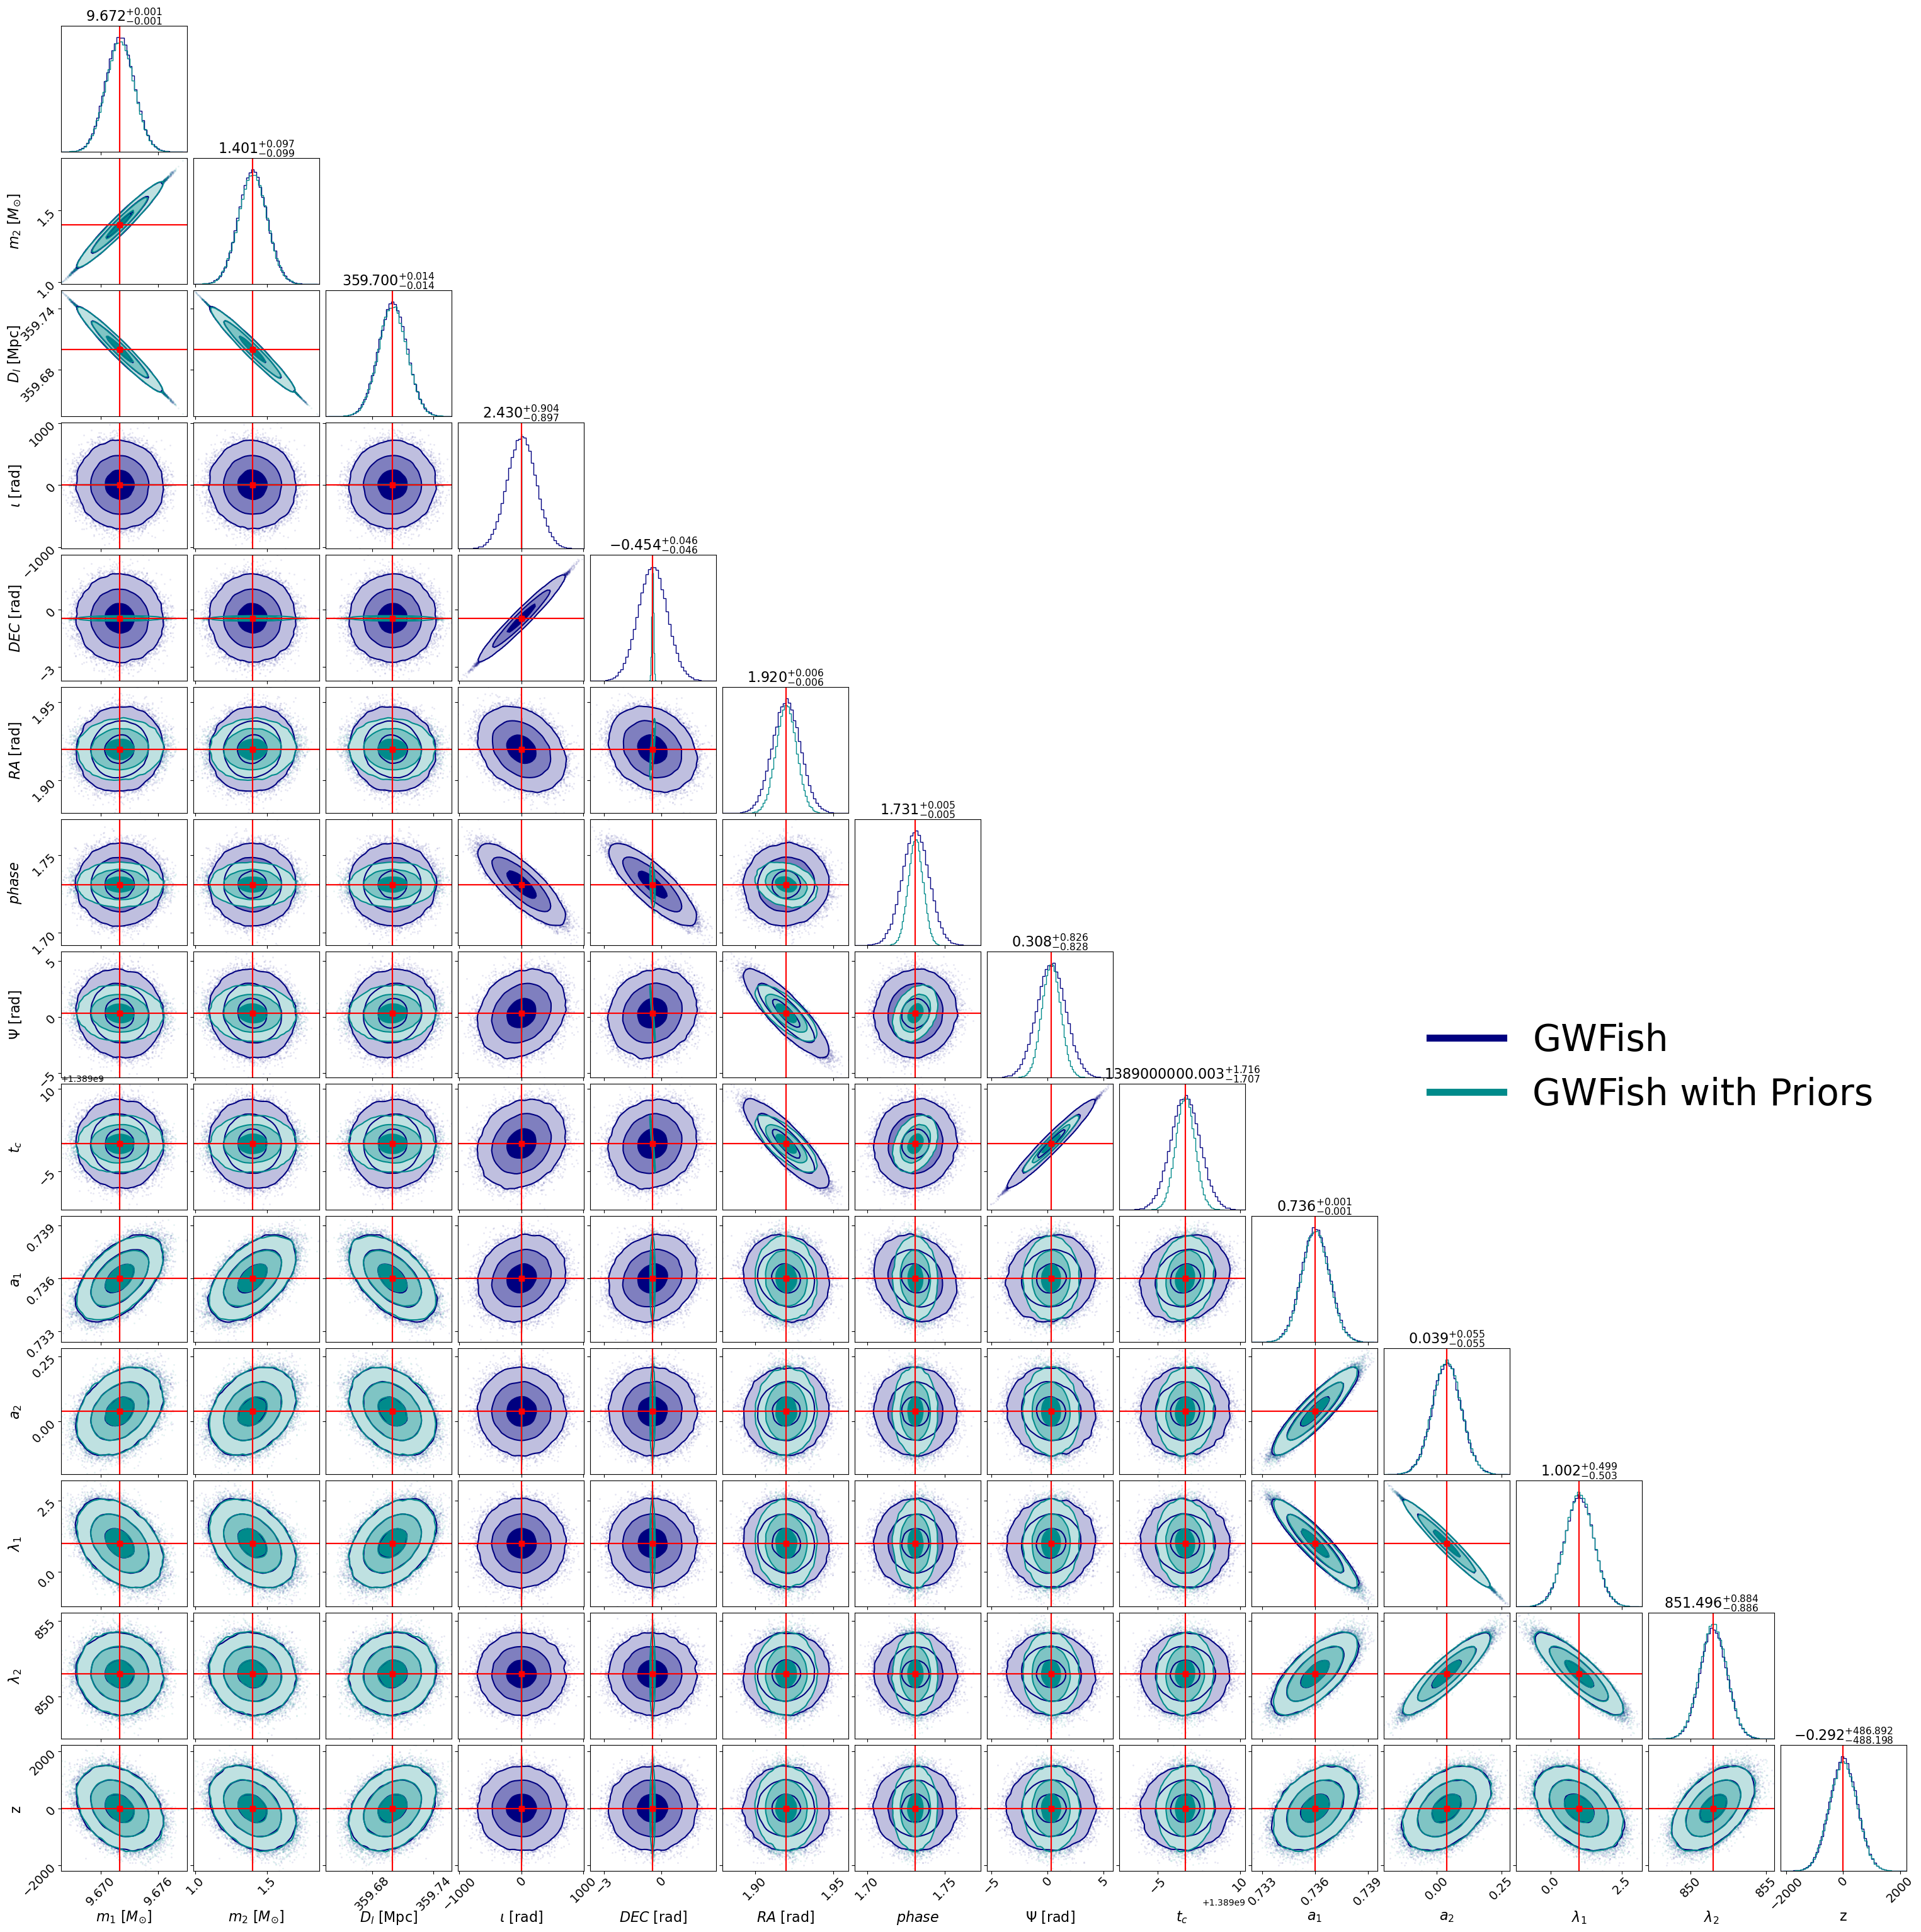

In [39]:
corner_lbs = [r'$m_1$ $[M_{\odot}]$', '$m_2$ $[M_{\odot}]$', '$D_l$ [Mpc]','$\iota$ [rad]',
                '$DEC$ [rad]', '$RA$ [rad]', 
                '$phase$','$\Psi$ [rad]','$t_c$', '$a_{1}$','$a_{2}$','$\lambda_1$','$\lambda_2$','z']

mean_values = means_event
cov_matrix = cov_event
prior_cov_matrix = new_cov

# Sample from a multi-variate gaussian with the given covariance matrix and injected mean values
samples = np.random.multivariate_normal(mean_values, cov_matrix, int(1e5))
samples_prior = np.random.multivariate_normal(mean_values, prior_cov_matrix, int(1e5))


colors = ['navy', 'darkcyan']

#colors= plt.colormaps['viridis'](np.linspace(0.6, 0.95, 2))
                                 
sample_labels = ['GWFish', 'GWFish with Priors']
fig = corner.corner(samples, labels = corner_lbs, truths = mean_values, truth_color = 'red', color = colors[0], **CORNER_KWARGS)

fig = corner.corner(samples_prior, fig = fig,     truths=mean_values, truth_color = 'red', color = colors[1], **CORNER_KWARGS)


for ax in fig.get_axes():
    ax.tick_params(axis = 'both', which = 'major', labelsize = 14, pad = 0.1)

plt.legend(
        handles = [
            mlines.Line2D([], [], linewidth=8, color=colors[i], label = sample_labels[i])
            for i in range(2)
        ],
        fontsize = 42, frameon = False,
        bbox_to_anchor = (1, 7), loc = "upper right"
    )
plt.show()

In [44]:
new_cov = np.zeros((number_events, number_parameters, number_parameters))
new_parameter_errors = np.zeros((number_events, number_parameters))

if ('ra' in var_in_cov_matrix) and ('dec' in var_in_cov_matrix):
    sky_localization = np.zeros((number_events,))


number_of_samples = 1e6

for k in tqdm(np.arange(number_events)):
    
    means_event = np.array(means.iloc[k])
    cov_event = cov_data[k, :, :]

    samples = np.random.multivariate_normal(means_event, np.squeeze(cov_event), int(number_of_samples))

    # Create samples dataframe to pass thruogh priors masks
    data_samples = {'mass_1':samples[:, 0],
                    'mass_2':samples[:, 1],
                    'luminosity_distance':samples[:, 2],
                    'theta_jn':samples[:, 3],
                    'dec':samples[:, 4],
                    'ra':samples[:, 5],
                    'phase':samples[:, 6],
                    'psi':samples[:, 7],
                    'geocent_time':samples[:, 8],
                    'a_1':samples[:, 9],
                    'a_2':samples[:, 10],
                    'lambda_1':samples[:, 11],
                    'lambda_2':samples[:, 12],
                    'redshift':samples[:, 13],
                    }

    data = pd.DataFrame(data = data_samples)

    # Choose which priors to combine
    #mask_mass = gw.priors.mass_prior(samples)
    mask_distance = gw.priors.distance_prior(data)
    mask_ra = gw.priors.ra_prior(data)
    mask_dec = gw.priors.dec_prior_uniform(data)

    mask_iota = gw.priors.iota_prior_uniform(data)
    mask_phase=gw.priors.phase_prior(data)
    mask_psi = gw.priors.psi_prior(data)
    mask_time = gw.priors.time_prior(data)

    mask_spin = gw.priors.uniform_priors_spins(data)


    def lambda1_prior(samples, min_value = 0., max_value = 10):
        lower = samples['lambda_1'] > min_value
        upper = samples['lambda_1'] < max_value
        return np.logical_and(lower, upper)

    def lambda2_prior(samples, min_value = 0., max_value = 3000):
        lower = samples['lambda_2'] > min_value
        upper = samples['lambda_2'] < max_value
        return np.logical_and(lower, upper)


    mask_lambda1=lambda2_prior(data)
    mask_lambda2=lambda2_prior(data)

    #----------------------------------------------------------------------------------------------------
    mask1 = np.logical_and( mask_distance, np.logical_and(mask_ra, mask_dec))
    mask2 = np.logical_and(np.logical_and(mask_iota, mask_phase), np.logical_and(mask_psi, mask_time))

    mask_lambda=np.logical_and(mask_lambda1,mask_lambda2)

    mask3=np.logical_and(mask_lambda,mask_spin)

    mask=np.logical_and(np.logical_and(mask1, mask2),mask3)
    #------------------------------------------------------------------------------------------------------
    
    # Filter data samples
    data_filtered = data.loc[mask]
    new_cov[k, :, :] = np.cov((data_filtered.to_numpy()).T)
    new_parameter_errors[k, :] = np.sqrt(np.diagonal(new_cov[k, :, :]))

    if ('ra' in var_in_cov_matrix) and ('dec' in var_in_cov_matrix):
        sky_localization[k] = np.pi * np.abs(np.cos(means_event[idx_dec])) *\
                            np.sqrt(new_cov[k, idx_ra, idx_ra] * new_cov[k, idx_dec, idx_dec]\
                            - new_cov[k, idx_ra, idx_dec]**2)

np.save('/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results/New_Cov_Matrices.npy', new_cov) 

if ('ra' in var_in_cov_matrix) and ('dec' in var_in_cov_matrix):
    data_to_save = np.c_[means, new_parameter_errors, sky_localization]
    header = ' '.join(['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'dec', 'ra', 'psi', 'phase','geocent_time','a_1','a_2','lambda_1','lambda_2','redshift','err_mass_1','err_mass_2','err_luminosity_distance','err_theta_jn', 'err_dec','err_ra','err_psi','err_phase', 'err_geocent_time','err_a_1','err_a_2','err_lambda_1','err_lambda_2','err_redshift','err_sky_location'])
    np.savetxt('/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results/New_Errors.txt', data_to_save, delimiter=' ', fmt='%.8f', header=header, comments='')
else:
    data_to_save = np.c_[means, new_parameter_errors]
    header = 'mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'dec', 'ra', 'psi', 'phase','geocent_time','a_1','a_2','lambda_1','lambda_2','redshift','err_mass_1','err_mass_2','err_luminosity_distance','err_theta_jn', 'err_dec','err_ra','err_psi','err_phase', 'err_geocent_time','err_a_1','err_a_2','err_lambda_1','err_lambda_2','err_redshift'
    np.savetxt('/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results/New_Errors.txt', data_to_save, delimiter=' ', fmt='%.8f', header=header, comments='')

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


In [65]:
err_lbs= ['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'dec', 'ra', 'psi', 'phase','geocent_time','a_1','a_2','lambda_1','lambda_2','redshift',
          'err_mass_1','err_mass_2','err_luminosity_distance','err_theta_jn', 'err_dec','err_ra','err_psi',                    
               'err_phase', 'err_geocent_time','err_a_1','err_a_2','err_lambda_1','err_lambda_2','err_redshift','err_sky_location' ]

new_errors = pd.read_csv('/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results/New_Errors.txt', names = err_lbs, delimiter = ' ',
                        low_memory = False, skiprows = 1)

In [66]:
new_errors


mass_1  mass_2  luminosity_distance  theta_jn      dec      ra     psi  \
0    8.968     1.4                307.2    1.2260 -0.46190  0.6149  1.7110   
1   10.350     1.4                447.9    0.7100  0.34030  6.2220  1.3540   
2   11.070     1.4                128.2    1.2340 -0.62080  0.9712  1.9920   
3    4.581     1.4                382.4    1.9750 -1.00400  0.1986  0.6320   
4    7.030     1.4                424.9    0.6277 -0.50970  2.4500  1.2290   
..     ...     ...                  ...       ...      ...     ...     ...   
95  13.620     1.4                309.9    2.1850  0.14900  1.0760  0.2682   
96  14.220     1.4                180.8    2.1840 -0.47220  4.2890  0.2546   
97  16.030     1.4                445.8    2.6670 -0.95950  2.9610  2.3670   
98   5.403     1.4                389.6    0.8158 -0.67630  3.1680  1.9930   
99  15.820     1.4                382.1    1.3500 -0.04351  2.4750  2.6570   

    phase  geocent_time     a_1  ...    err_ra   err_psi  err_phase  \
0   1.760  1.403000e+09  0.3607  ...  0.121397  0.080508   0.035269   
1   5.301  1.389000e+09  0.6423  ...  0.031227  0.013924   0.571240   
2   4.950  1.402000e+09  0.7115  ...  0.278791  0.132064   0.137128   
3   4.742  1.403000e+09  0.4243  ...  0.131767  0.060115   0.039380   
4   1.964  1.401000e+09 -0.4358  ...  0.035483  0.035981   1.239253   
..    ...           ...     ...  ...       ...       ...        ...   
95  4.572  1.399000e+09  0.6264  ...  0.109069  0.025959   0.198729   
96  2.066  1.397000e+09 -0.1338  ...  0.094075  0.111609   0.079083   
97  3.867  1.402000e+09  0.5638  ...  0.011154  0.007618   1.746902   
98  2.094  1.392000e+09 -0.1353  ...  0.110515  0.064556   0.327083   
99  6.250  1.400000e+09 -0.2291  ...  0.100852  0.291567   0.104182   

    err_geocent_time   err_a_1   err_a_2  err_lambda_1  err_lambda_2  \
0           0.506771  0.002848  0.151389      1.245385     12.594724   
1           1.264264  0.001202  0.077392      0.743917      1.784170   
2           0.060826  0.000241  0.011356      0.121010      0.189388   
3           0.281598  0.001552  0.276787      1.093939     10.833048   
4           2.548687  0.001898  0.206105      1.345105     14.424461   
..               ...       ...       ...           ...           ...   
95          0.613356  0.001411  0.037662      0.489327      0.845939   
96          0.225274  0.000783  0.030738      0.427887     27.764759   
97          3.493765  0.001350  0.038055      0.578848      1.094288   
98          0.634797  0.001666  0.224260      1.051024     90.545317   
99          1.091611  0.003555  0.114910      1.781029     36.194638   

    err_redshift  err_sky_location  
0    1737.629711          0.002376  
1    1220.827730          0.001060  
2     129.201551          0.001276  
3     440.126778          0.002651  
4     854.052332          0.002500  
..           ...               ...  
95   1553.933090          0.002091  
96   1506.318945          0.001516  
97   3801.861916          0.000395  
98    531.755568          0.014765  
99   5712.522241          0.001461  

[100 rows x 29 columns]

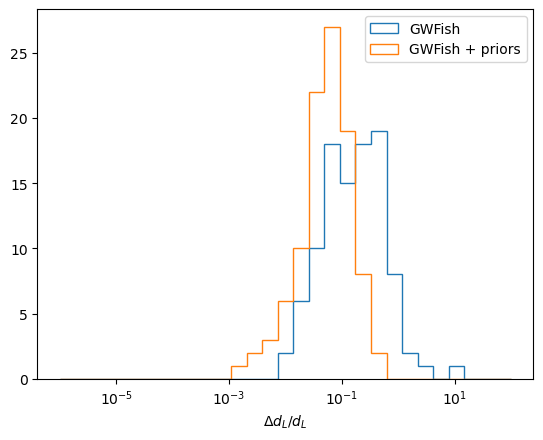

In [67]:
my_bins = np.logspace(-6, 2, 30)
plt.hist(means_data['err_luminosity_distance']/means_data['luminosity_distance'], 
         bins = my_bins, histtype = 'step', label = 'GWFish')
plt.hist(new_errors['err_mass_2']/new_errors['mass_2'], 
         bins = my_bins, histtype = 'step', label = 'GWFish + priors')

plt.legend()
plt.xlabel('$\Delta d_L / d_L$')
plt.xscale('log')
plt.show()

0.0
-0.6931471805599453
-4.605170185988091


/tmp/ipykernel_24400/2534826386.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(1-x/100)


Text(0, 0.5, '$a_{BH}$ (final BHspin)')

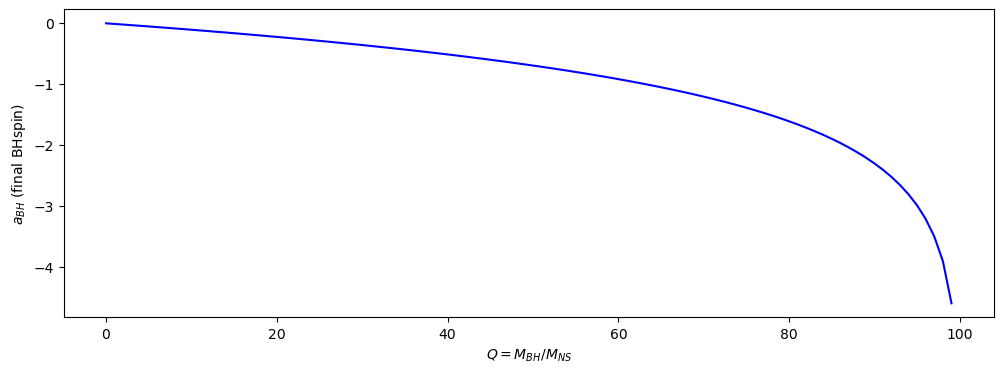

In [38]:
def function(x):
    return np.log(1-x/100)


plt.figure(figsize=[12, 4])
x=np.linspace(0,100,100)
print(function(0))
print(function(50))
print(function(99))

plt.plot(x, function(x), ls='-', color="blue")
    
plt.xlabel('$Q = M_{BH}/M_{NS}$')
plt.ylabel('$a_{BH}$ (final BHspin)')
#plt.title('$\Lambda$={} (Tidal deformability)'.format(la))
#plt.legend(title="Initial BH spin")
#plt.grid(True, alpha=0.3, linestyle='--')
#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(-.1, .01)
# plt.grid(True)plt.show()